In [14]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import rasterio
import numpy as np
import datetime as dt
from rasterstats import zonal_stats
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.colors import TwoSlopeNorm

In [2]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')
mandal_boundaries = mandal_boundaries.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\Landuse_Analysis')


In [3]:
def crop_counts(boundaries, year):
    tiff = '01-01-'+str(year)+'.tif'
    lulc = rasterio.open(tiff, mode = 'r')
    lulc_array = lulc.read(1) # landuse corresponding to each rasterpixel, so we extracted the pixel values from the raster
    # affine: 1: corresponds to the width of each pixel, 2: row rotation, 3: x-coordinate of the upper left pixel, 4: column rotation, 5: height of each pixel, 6: y-coordinate of the upper left pixel
    affine = lulc.transform

    cmap = {1: 'Water', 2: 'Trees', 4: 'Flooded Vegetation', 5: 'Crops', 7: 'Built Area', 8: 'Bare Ground', 9: 'Snow/Ice', 10: 'Clouds', 11: 'Rangeland'}
    boundaries['Crops ' + str(year)] = 0

    for i in range(0, len(boundaries)):
        test = zonal_stats(boundaries.iloc[i].geometry, lulc_array, affine = affine, geojson_out = True, nodata = lulc.nodata, categorical=True, category_map = cmap)
        try:
            boundaries['Crops ' + str(year)].iloc[i] = test[0]['properties']['Crops']  
        except:
            boundaries['Crops ' + str(year)].iloc[i] = 0
        
    return (boundaries)

In [5]:
for a in range(2017, 2022):
    mandal_boundaries = crop_counts(mandal_boundaries, a)
    print('Year ' + str(a) + ' is completed.')

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Year 2017 is completed.
Year 2018 is completed.
Year 2019 is completed.
Year 2020 is completed.
Year 2021 is completed.


In [38]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\Crop')
crops_df = mandal_boundaries[['Crops 2017', 'Crops 2018', 'Crops 2019', 'Crops 2020', 'Crops 2021']]
crops_df.to_csv('Crops_years.csv')

In [5]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\Crop')
crops_df = pd.read_csv('Crops_years.csv', index_col=0 )
crops_df = crops_df.transpose()
crops_df = crops_df.reset_index()
crops_df['day'] = 1 
crops_df['year'] = [2017, 2018, 2019, 2020, 2021]
crops_df['month'] = 1
crops_df['ModifiedDateTime'] = pd.to_datetime(crops_df[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)
crops_df['ModifiedDateTime_num'] = crops_df['ModifiedDateTime'].map(dt.datetime.toordinal)

In [6]:
crops_df

,index,0,1,2,3,4,5,6,7,8,...,587,588,589,590,591,day,year,month,ModifiedDateTime,ModifiedDateTime_num
0,Crops 2017,849836,1975611,812996,1268147,1082324,1256216,74094,2636072,1504092,...,239109,300628,832802,453161,679970,1,2017,1,2017-01-01,736330
1,Crops 2018,802551,2078593,861867,1300430,1130839,1450355,80052,2642390,1530209,...,245527,300674,877785,488000,688364,1,2018,1,2018-01-01,736695
2,Crops 2019,902137,1839440,847520,1328201,1026739,1377551,74407,2613427,1540098,...,247084,301379,903907,493215,689191,1,2019,1,2019-01-01,737060
3,Crops 2020,761404,2066133,844137,1294461,1139548,1282916,73218,2634133,1568421,...,242441,318042,909823,476468,681570,1,2020,1,2020-01-01,737425
4,Crops 2021,844641,2182740,889952,1296141,1159068,1393983,77866,2671878,1570838,...,247101,320116,872330,486953,680995,1,2021,1,2021-01-01,737791


In [18]:
scores = []

for i in mandal_boundaries['index']:

    #Set the data in the right format for Linear Regression
    X = np.array(crops_df['ModifiedDateTime_num'])
    X = X.reshape(-1, 1)
    y = np.array(crops_df[i])
    y = y.reshape(-1, 1)

    #Perform Linear Regression and obtain the slope
    reg = LinearRegression().fit(X, y)
    y_pred_trend = reg.predict(X)
    slope, intercept = np.polyfit(np.array(crops_df['ModifiedDateTime_num']), y_pred_trend,1)
    line_slope = slope[0]

    scores.append(line_slope)

In [19]:
data={'index': mandal_boundaries.index, 'scores':scores,'geometry':mandal_boundaries['geometry']}

df=pd.DataFrame(data)

df = gpd.GeoDataFrame(df, geometry = df.geometry, crs = {'init': 'epsg:4326'}) 

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


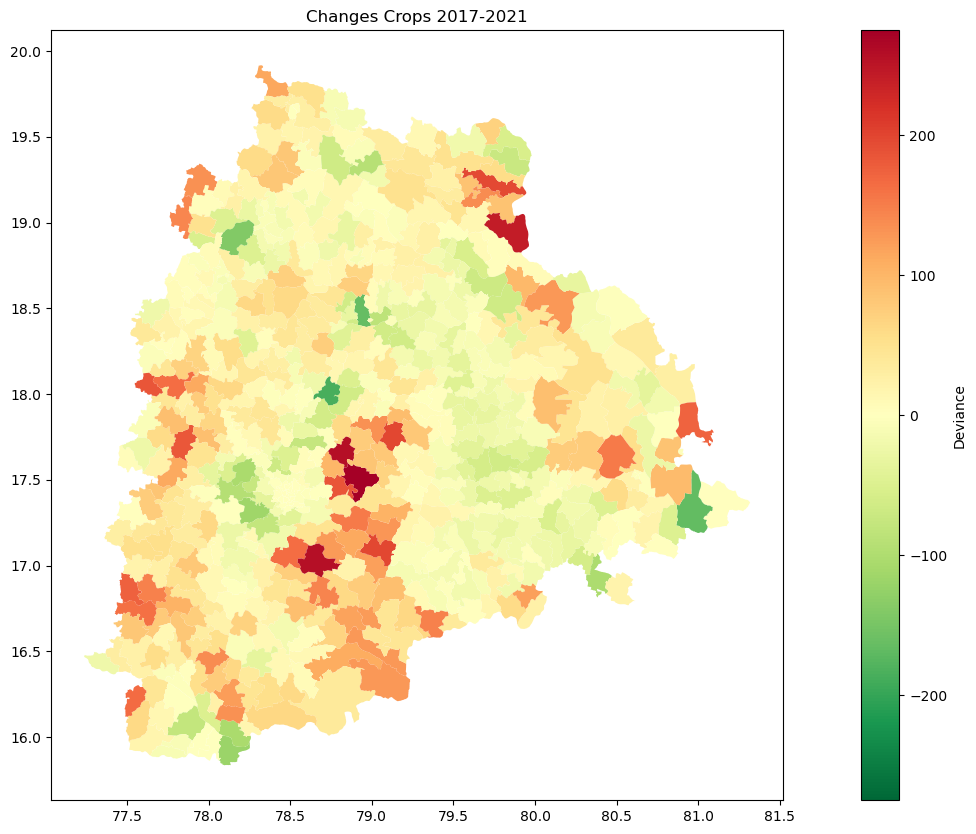

In [22]:
text = 'Changes Crops 2017-2021'
ranges = max(abs(df['scores'].min()), (df['scores'].max()))
vmin, vmax, vcenter = ranges*-1 , ranges, 0
norm = TwoSlopeNorm(vmin= vmin , vcenter=vcenter, vmax= vmax) 
# create a normalized colorbar
cmap = 'RdYlGn_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
df.plot(column = 'scores', 
                    legend = True, 
                    figsize = [20,10],\
                    legend_kwds = {'label': 'Deviance'}, 
                    cmap = 'RdYlGn_r',
                    norm = norm)
plt.title(text)
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\Crop\\result')
plt.savefig(text + '.png', bbox_inches='tight')
plt.show()

In [23]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\Fires\\results')
DPPD_Fires = pd.read_csv('DPPD_Fires_2017-2021.csv', index_col = 0)
DPPD_Fires.columns = ['index', 'Slope Score Fires', 'geometry']

Corr = DPPD_Fires.merge(df[['scores', 'index']], how = 'left', on = ['index'])

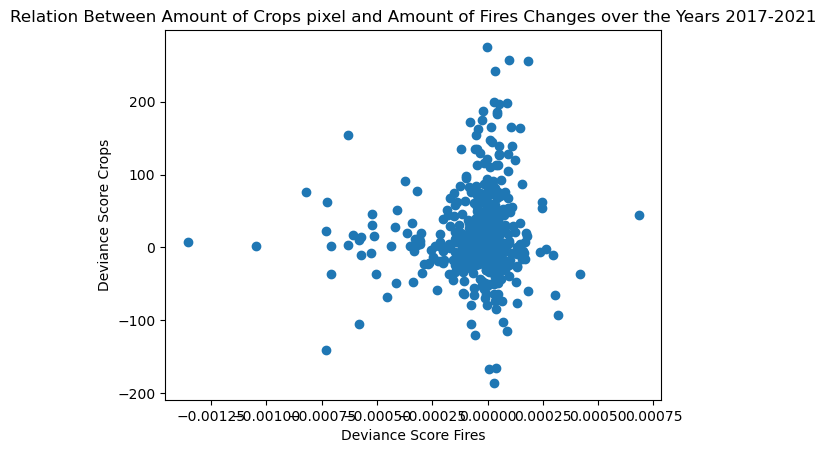

Pearsons correlation: 0.069


In [24]:
plt.scatter(Corr['Slope Score Fires'], Corr['scores'])
plt.title('Relation Between Amount of Crops pixel and Amount of Fires Changes over the Years 2017-2021')
plt.xlabel('Deviance Score Fires')
plt.ylabel('Deviance Score Crops')
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\Crop\\result')
plt.savefig('Relation between Amount of Crops and Fires Changes.png', bbox_inches='tight')
plt.show()

corr, _ = pearsonr(Corr['Slope Score Fires'], Corr['scores'])
print('Pearsons correlation: %.3f' % corr)